# Local Active Learning

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Active Learning workflow for increasing the training data of a DNN. Incorporates an API to automatically generate FEM calculations with IDEA Statica. 

*Local* Active Learning refers to adding new load combinations to existing designs. The workflow is structured as follows:
1. Identify design, where the DNN has increased *uncertainty*, and/or *error*
2. Optimaly select new load combinations to be added to the identified designs
3. Calculate the load capacities with the API for the identified designs with the obtained load combinations
4. Add to the trainin data and finetune the DNN
5. Repeat 1-4 until satisfied

**IMPORTANT**: Change `idea_path` variable in `API.py` to the path of IDEA Statica

**Dependencies**: 
- `Datareader.py`
- `Settings.py`
- `DNN.py`
- `Saved Models\DNN_Model_Full_V2`
- `AL_API\API.py`
- `AL_API\Corner_Stiff_Wid.ideaCon`
- `AL_API\Corner_Stiff2_Wid.ideaCon`
- `AL_API\Corner.ideaCon`
- `AL_API\Corner_Stiffner.ideaCon`

**Generates**:
- `Data\Extended_Database.csv`
- `Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth`




## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math
import random
import time
import pickle

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
import torch

from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


### Load Forward Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization


### Generate (or load) data uncertainties

#### Generate

In [6]:
#mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)

In [7]:
#uncertainty_full = mcd_std_full / mcd_mean_full
#np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

#### Load

In [8]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

## Illustrate workflow

### 1. Find most uncertain profiles

In [159]:
most_uncertain_samples = np.argsort(uncertainty_full)[-10:]
df_most_uncertain = df_full.loc[most_uncertain_samples]

In [160]:
y_preds, _ = model.predict(df_full)
y_truths = df_full['target'].values

In [161]:
rel_error = (y_truths-y_preds.numpy().flatten())/ y_truths

In [162]:
most_error_samples = np.argsort(np.abs(rel_error))[-10:]
df_most_error = df_full.loc[most_error_samples]

In [163]:
uncertainty_full = rel_error

Define geometric & material features, which define a profile. (No loads)

In [164]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

Taking the most uncertain values is not a good strategy, since most of them will be from the same profile (different load combinations).

In [165]:
df_most_uncertain[fixed_features].duplicated(keep=False)

151176     True
150830     True
150833     True
151169     True
151175     True
151177     True
151063     True
151879    False
172722    False
151062     True
dtype: bool

Instead form groups according to the profile dimensions (identical geometry/material, different load combinations).

In [166]:
identical_groups = df[fixed_features].groupby(list(df[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
print(f"Number of identical groups: {len(identical_groups)}")

Number of identical groups: 152259


Get the max uncertainty for each group:

In [167]:
group_uncertainty = np.array([uncertainty_full[group].max() for group in identical_groups])

Get the n most uncertain groups:

In [168]:
most_uncertain_groups = np.argsort(group_uncertainty)[-10:]

Most uncertain group of profiles:

In [ ]:
most_uncertain_group_ids = identical_groups[most_uncertain_groups[0]]

Select one profile of the group to serve as a template (does not matter which, since all have identical features):

In [177]:
base_id = most_uncertain_group_ids[0]
base_profile = df_full.iloc[base_id:base_id+1].copy()
group_profiles = df_full.iloc[most_uncertain_group_ids].copy()
group_uncertainty = uncertainty_full[most_uncertain_group_ids]

Identify possible calculation mismatches early with random forst model:

In [171]:
with open(r'Saved Variables\RF_calculation_validation.pkl', 'rb') as f:
    error_identifier_package = pickle.load(f)

rf_raw_features = error_identifier_package['features']
forest = error_identifier_package['model']

In [178]:
calculation_error_prediction = forest.predict(base_profile[rf_raw_features].values)[0]

if calculation_error_prediction == 1:
    print("The base profile is predicted to have a calculation error.")

The base profile is predicted to have a calculation error.


### 2. Get new load combination

Function to find the location (M/V contribution) of new load combinations, based on the location and uncertainty of existing points.

In [179]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    if uncertainty.max() - uncertainty.min() == 0:
        uncertainty_normalized = (uncertainty - uncertainty.min())
    else:
        uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)]

def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    return M_contribution, V_contribution

In [180]:
ratio = find_optimal_location(group_profiles['V_contribution'].values, group_uncertainty) # M or V needed?
M_contribution, V_contribution = get_MV_contribution(ratio)

new_profile = base_profile.copy()
new_profile['M_contribution'] = round(M_contribution,6)
new_profile['V_contribution'] = round(V_contribution,6)

print(f"Optimal ratio: {ratio}")
print(f"Optimal M_contribution: {M_contribution}")
print(f"Optimal V_contribution: {V_contribution}")

Optimal ratio: 0.3535353535353536
Optimal M_contribution: 0.8497254299495144
Optimal V_contribution: 0.5272254676105025


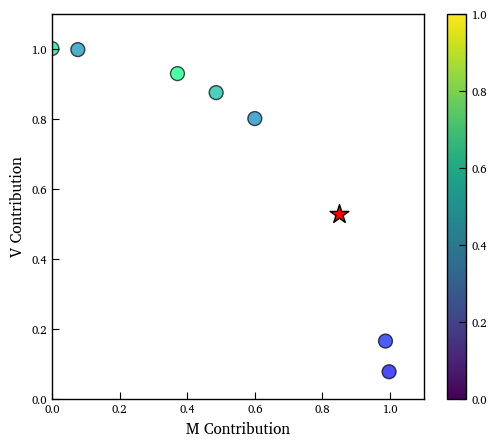

In [181]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M_contribution'], group_profiles['V_contribution'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M_contribution'], new_profile['V_contribution'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel('M Contribution')
plt.ylabel('V Contribution')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.colorbar()

plt.show()

In [182]:
current_id = len(df_full)

new_profile.index = [current_id]
new_profile['M_Rd'] = None
new_profile['V_Rd'] = None
new_profile['M'] = None
new_profile['V'] = None
new_profile['proz'] = None

This is the resulting profile. The geometric and material features are taken from the base profile (template), only the load combination is novel. 

In [183]:
new_profile

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,Steel grade_x,fy_x,tau_x,Vpl_x,Mpl_x,Profile_y,h_y,b_y,tw_y,tf_y,A_y,Av_y,Iy_y,Wely_y,Wply_y,Steel grade_y,fy_y,tau_y,Vpl_y,Mpl_y,Gamma,t_stiffc,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffb,Offset,Offset_Idea,M,V,proz,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,0.261799,0,0.0,0.0,0,0,0,0,0.0,18.649264,None,None,None,None,None,0.527225,0.849725,0.033198,0.431592,0.432867,0,0,NaN


Convert `M_contribution`and `V_contribution`to loads $M$ and $V$:

In [184]:
def get_MV(profile):
    Mplx = profile['Mpl_x']
    Mply = profile['Mpl_y']
    Vplx = profile['Vpl_x']
    Vply = profile['Vpl_y']
    V_cont = profile['V_contribution']
    M_cont = profile['M_contribution']

    ratio = V_cont / (M_cont +1e-12)
    Vmax = np.max([Vplx, Vply])
    Mmax = np.max([Mplx, Mply])
    Mnorm = Mmax / Mply
    Vnorm = Vmax / Vply
    
    M = Vnorm / (ratio + Vnorm / Mnorm)
    V = ratio * M

    profile['M'] = M*Mply
    profile['V'] = V*Vply

In [185]:
get_MV(new_profile)

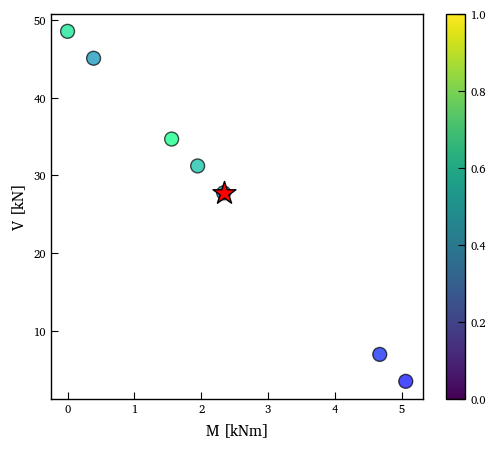

In [187]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M'], group_profiles['V'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M'], new_profile['V'],
            c='red', s=300, edgecolor='black', label='New Profile', marker='*')

plt.xlabel(plot_params.feature_labels['M'])
plt.ylabel(plot_params.feature_labels['V'])

plt.colorbar()

plt.show()

### 3. Calculate Resistance with API

In [188]:
directory.reset_root()
os.chdir(r"AL_API")
from API import IdeaConnectionClient

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


Absolute Paths are needed.

In [189]:
PATH = os.path.join(directory.root, "AL_API")

There are four idea templates. Depending on the existence of certain features, different templates have to be chosen. Depending on the lowest nonzero feature (see image), the according template is chosen.

<img src="templates.png" alt="image" width="600"/>

In [190]:
# All template names
ideatemplates_filenames = ['Corner.ideaCon',
                        'Corner_Stiffner.ideaCon',
                        'Corner_Stiff_Wid.ideaCon',
                        'Corner_Stiff2_Wid.ideaCon']

# Features that vary across templates
variable_features = ['t_stiffc',
                'h_wid',
                'b_wid',
                'd_wid',
                't_fwid',
                't_wwid',
                't_stiffb'
                ]

# How many variables each template has (e.g. Corner is the most simplest template and has 0 variable features)
existing_variable_features = {'Corner.ideaCon':0,
                              'Corner_Stiffner.ideaCon':1,
                              'Corner_Stiff_Wid.ideaCon':6,
                              'Corner_Stiff2_Wid.ideaCon':7}

existing_variable_features_indices = np.array(list(existing_variable_features.values()))

# Function to retrieve the ideal template based on the profile
def get_ideatemplate(profile):
    values = profile[variable_features].fillna(0).astype(float).values.flatten()
    nonzero_indices = np.nonzero(values)[0]
    highest_nonzero_index = 0 if len(nonzero_indices) == 0 else np.max(nonzero_indices) + 1
    ideatemplate_id = np.nanargmin(np.abs(existing_variable_features_indices - highest_nonzero_index))
    return ideatemplates_filenames[ideatemplate_id]

Find the template for the considered profile and open it in IdeaStatica.

In [ ]:
inputs = new_profile.copy()
ideatemplate = get_ideatemplate(inputs)
IdeaName = os.path.join(PATH,ideatemplate)

inputs['template'] = ideatemplate

conn = IdeaConnectionClient()
conn.open(IdeaName)

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiff2_Wid.ideaCon


### 4. Prepare

Adjust the feature labeling and the unit scaling to match with IdeaStatica.

In [229]:
i=inputs.index[0]  

params = {
    'Prof_c': inputs.at[i, 'Profile_x'], 'Prof_b': inputs.at[i, 'Profile_y'],
    'steel_grade': inputs.at[i, 'Steel grade_x'], 'gamma': inputs.at[i, 'Gamma'], 
    'h_wid': inputs.at[i, 'h_wid']/1000, 'b_wid': inputs.at[i, 'b_wid']/1000,
    'd_wid': inputs.at[i, 'd_wid']/1000, 't_fwid': inputs.at[i, 't_fwid']/1000,
    't_wwid': inputs.at[i, 't_wwid']/1000, 
    't_stiffc': inputs.at[i, 't_stiffc']/1000, 't_stiffb': inputs.at[i, 't_stiffb']/1000,
    'offset': inputs.at[i, 'Offset']/1000  
}

Load parameters into IdeaStatice to build the profile.

In [230]:
conn.update_params_by_name(params)
if not conn.params_valid():
    raise Exception("Parameters validation failed.")

#### 5. Define Loads

Functions to adjust loads incrementely up (underloaded) or down (overloaded).

In [231]:
def overloaded(calculated,profiles,i):
    overload_counter=0
    while calculated == False:
        print('k =', overload_counter)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=0.9
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=0.9
        else:
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=0.9
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] ) 
        calculated = conn.calculate()
        overload_counter=(overload_counter+1)
        if overload_counter == 100:
            break
        
# In case of underload,, get in the loop and decrease the load:
def underloaded(applied_percentage,profiles,i):
    underload_counter=0
    while applied_percentage == 1:
        print('j =', underload_counter)
        print('Applied percentage =',applied_percentage)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=1.1
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=1.1
        else:    
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=1.3
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] )    
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,profiles,i)
        
        # Get the applied loads:
        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']
        underload_counter=(underload_counter+1)

    return results, loads, applied_percentage

In [232]:
loads = conn.get_loads()

loads[0]['forcesOnSegments'][1]['my'] = int(inputs.at[i,'M']*1000)
loads[0]['forcesOnSegments'][1]['qz'] = int(inputs.at[i,'V']*1000)#!!!!

conn.set_loads(loads) 
print('M=',loads[0]['forcesOnSegments'][1]['my'] )
print('V=',loads[0]['forcesOnSegments'][1]['qz'] )            

M= 0
V= 0


In [233]:
new_profile['M'] = inputs['M'].values[0]
new_profile['V'] = inputs['V'].values[0]

### 6. Calculate

Calculate ...

In [234]:
calculated = conn.calculate()

if calculated == False:
    overloaded(calculated, new_profile, new_profile.index[0])

k = 0
M= 0
V= 0
k = 1
M= 0
V= 0
k = 2
M= 0
V= 0
k = 3
M= 0
V= 0
k = 4
M= 0
V= 0
k = 5
M= 0
V= 0
k = 6
M= 0
V= 0
k = 7
M= 0
V= 0
k = 8
M= 0
V= 0
k = 9
M= 0
V= 0
k = 10
M= 0
V= 0
k = 11
M= 0
V= 0
k = 12
M= 0
V= 0
k = 13
M= 0
V= 0
k = 14
M= 0
V= 0
k = 15
M= 0
V= 0
k = 16
M= 0
V= 0
k = 17
M= 0
V= 0
k = 18
M= 0
V= 0
k = 19
M= 0
V= 0
k = 20
M= 0
V= 0
k = 21
M= 0
V= 0
k = 22
M= 0
V= 0
k = 23
M= 0
V= 0
k = 24
M= 0
V= 0
k = 25
M= 0
V= 0
k = 26
M= 0
V= 0
k = 27
M= 0
V= 0
k = 28
M= 0
V= 0
k = 29
M= 0
V= 0
k = 30
M= 0
V= 0
k = 31
M= 0
V= 0
k = 32
M= 0
V= 0
k = 33
M= 0
V= 0
k = 34
M= 0
V= 0
k = 35
M= 0
V= 0
k = 36
M= 0
V= 0
k = 37
M= 0
V= 0
k = 38
M= 0
V= 0
k = 39
M= 0
V= 0
k = 40
M= 0
V= 0
k = 41
M= 0
V= 0
k = 42
M= 0
V= 0
k = 43
M= 0
V= 0
k = 44
M= 0
V= 0
k = 45
M= 0
V= 0
k = 46
M= 0
V= 0
k = 47
M= 0
V= 0
k = 48
M= 0
V= 0
k = 49
M= 0
V= 0
k = 50
M= 0
V= 0
k = 51
M= 0
V= 0
k = 52
M= 0
V= 0
k = 53
M= 0
V= 0
k = 54
M= 0
V= 0
k = 55
M= 0
V= 0
k = 56
M= 0
V= 0
k = 57
M= 0
V= 0
k = 58
M= 0
V= 0
k = 59


#### Check if calculation was correct

Get results:

In [235]:
results = conn.get_results()
loads = conn.get_loads()
applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
if applied_percentage == 1:
    underloaded(applied_percentage,new_profile,new_profile.index[0])

applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

outputs = inputs.copy()

outputs.at[i, 'proz'] = applied_percentage
outputs.at[i, 'M_Rd'] = applied_M/1000 # [kNm]
outputs.at[i, 'V_Rd'] = applied_V/1000 # [kN]

cost = results['costEstimationResults']['totalEstimatedCost']
outputs.at[i, 'cost'] = cost

KeyError: '1'

Final profile with calculate moment and shear resistance.

In [ ]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,Steel grade_x,fy_x,tau_x,Vpl_x,Mpl_x,Profile_y,h_y,b_y,tw_y,tf_y,A_y,Av_y,Iy_y,Wely_y,Wply_y,Steel grade_y,fy_y,tau_y,Vpl_y,Mpl_y,Gamma,t_stiffc,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffb,Offset,Offset_Idea,M,V,proz,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,template
714385,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,0.261799,0,0.0,0.0,0,0,0,0,0.0,18.649264,2.336571,27.732457,0.902344,2.107875,25.023797,0.527225,0.849725,0.033198,0.431592,0.432867,0,0,3.693262,Corner_Stiffner.ideaCon


Calculate the target value from the resulting moment and shear resistance.

In [ ]:
def calculate_target_from_Rd(profile):
    profile['V_norm'] = abs(profile['V_Rd'] / profile['Vpl_y'])
    profile['M_norm'] = abs(profile['M_Rd'] / profile['Mpl_y'])
    profile['target'] = (profile['V_norm']**2 + profile['M_norm']**2)**0.5

In [ ]:
calculate_target_from_Rd(outputs)

In [ ]:
conn.close()

In [ ]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,Steel grade_x,fy_x,tau_x,Vpl_x,Mpl_x,Profile_y,h_y,b_y,tw_y,tf_y,A_y,Av_y,Iy_y,Wely_y,Wply_y,Steel grade_y,fy_y,tau_y,Vpl_y,Mpl_y,Gamma,t_stiffc,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffb,Offset,Offset_Idea,M,V,proz,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,template
714385,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,IPE80,80,46,3.8,5.2,764.340184,357.700184,801000,20000.0,23200,S 235,235,135.677313,48.5318,5.452,0.261799,0,0.0,0.0,0,0,0,0,0.0,18.649264,2.336571,27.732457,0.902344,2.107875,25.023797,0.527225,0.849725,0.515617,0.386624,0.644468,0,0,3.693262,Corner_Stiffner.ideaCon


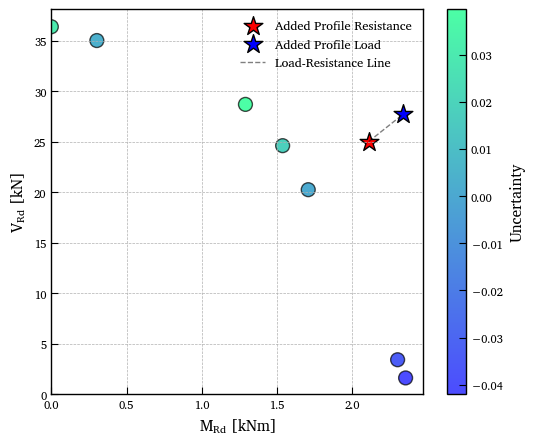

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

sc = plt.scatter(df_full.loc[most_uncertain_group_ids]['M_Rd'].values,
            df_full.loc[most_uncertain_group_ids]['V_Rd'].values,
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(outputs['M_Rd'].values,
            outputs['V_Rd'].values,
            c='red', s=200, edgecolor='black', label='Added Profile Resistance', marker='*')

plt.scatter(outputs['M'],
            outputs['V'],
            c='blue', s=200, edgecolor='black', label='Added Profile Load', marker='*')

plt.plot((outputs['M_Rd'].values, outputs['M'].values),(outputs['V_Rd'].values, outputs['V'].values),
         color='black', linestyle='--', linewidth=1, alpha=0.5, label='Load-Resistance Line')

plt.xlabel(plot_params.feature_labels['M_Rd'])
plt.ylabel(plot_params.feature_labels['V_Rd'])

plt.legend()
plt.colorbar(sc,label='Uncertainty')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### 7. Check if calculation was successful

In [85]:
df_group = df_full.loc[most_uncertain_group_ids].copy()
df_group = pd.concat([df_group, outputs], ignore_index=False)

In [86]:
def identify_computational_issue(df_group,threshold_x=0.2, threshold_y=0.2):
    if df_group.iloc[-1]['template'] != 'Corner.ideaCon':
        return False
    
    n_before = len(df_full)
    group = np.array(df_group.index)
    mask_before = np.where(np.array(group) < n_before)[0]
    mask_added = np.where(np.array(group) >= n_before)[0]

    M_Rd_calc = df_group['M_Rd'].values
    V_Rd_calc = df_group['V_Rd'].values

    base_profile = df_group.iloc[0].copy()
    M_Rd_pred, V_Rd_pred, _ = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

    # Calculate distance to interaction curve
    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
    added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T

    ids_on_y_axis = np.argmin(np.abs(added_resistances[:,0].reshape(-1,1)-interaction_curve[:,0]),axis=1)
    ids_on_x_axis = np.argmin(np.abs(added_resistances[:,1].reshape(-1,1)-interaction_curve[:,1]),axis=1)

    error_on_x = interaction_curve[:,0][ids_on_x_axis].astype(float) - added_resistances[:,0].astype(float)
    error_on_y = interaction_curve[:,1][ids_on_y_axis].astype(float) - added_resistances[:,1].astype(float)

    rel_error_on_y = error_on_y / interaction_curve[:,1][ids_on_y_axis]
    rel_error_on_x = error_on_x / interaction_curve[:,0][ids_on_x_axis]

    if np.isnan(rel_error_on_x).any() or np.isinf(rel_error_on_x).any() or (rel_error_on_x < 0).any():
        return False
    if np.isnan(rel_error_on_y).any() or np.isinf(rel_error_on_y).any() or (rel_error_on_y < 0).any():
        return False
    
    if np.all(rel_error_on_y>threshold_y) and np.all(rel_error_on_x>threshold_x):
        print("Error on X-axis:", rel_error_on_x)
        print("Error on Y-axis:", rel_error_on_y)
        return True
    
    return False

In [87]:
identify_computational_issue(df_group)

Error on X-axis: [0.92174434]
Error on Y-axis: [0.9559865]


True

## Local Active Learning

### Preperation

In [275]:
model_AL = copy.deepcopy(model)
df_AL = df_full.copy()

Identify are profiles that induce computational issues. Do not consider them in the Active Learning.

In [276]:
df_corner = df_AL[(df_AL['Cat_h'] == 0) & (df_AL['Cat_t_stiffc'] == 0)].copy()
computational_error_predictions = forest.predict(df_corner[rf_raw_features].values)
df_corner_filtered = df_corner[computational_error_predictions == 0].copy()

Reindex the filtered database.

In [277]:
df_AL_safe = df_AL.drop(index=df_corner.index.difference(df_corner_filtered.index))
original_ids = df_AL_safe.index.tolist()
df_AL_safe.reset_index(drop=True, inplace=True)
df_AL_safe['group_id'] = df_AL_safe[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL_safe.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

#### Define Learning Parameters

In [278]:
iterations = 1
groups_per_iter = 5
add_per_group = 2

finetuning_lr = model.config['learning_rate']
patience = 3

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 10
Added Samples: 10


In [279]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [280]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 0, 0)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 0
Total Epochs: 0


#### Define Save Options

In [281]:
save_interim_results = False

In [115]:
model_name = "DNN_Model_AL_Finetuned"
database_filename = "Extended_Database.csv"

MODEL_SAVE_PATH = os.path.join(directory.root, "Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

DATA_SAVE_FILE = os.path.join(directory.root, "Data", database_filename)

### Data Generation

#### Active Learning Loop

In [282]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_full)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL_safe)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL_safe['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL_safe.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL_safe.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL_safe.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            #print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        get_MV(new_profiles)

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in ['Corner.ideaCon', 'Corner_Stiffner.ideaCon', 'Corner_Stiff_Wid.ideaCon']:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            #print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,df_new_profiles,profile_id)
            end_time = time.time()

            df_new_profiles.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1.0:
                results, loads, applied_percentage = underloaded(applied_percentage,df_new_profiles,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save_interim_results:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL_safe = pd.concat([df_AL_safe, df_new_profiles], ignore_index=False)

*** Iteration 1/1 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 12980)
   Processing Group 20.00% (Group id: 3340)
   Processing Group 40.00% (Group id: 14246)
   Processing Group 60.00% (Group id: 7502)
   Processing Group 80.00% (Group id: 10478)
Unique templates in this iteration: ['Corner_Stiffner.ideaCon']
   Open Idea for template: Corner.ideaCon
c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner.ideaCon
   Close Idea
   Open Idea for template: Corner_Stiffner.ideaCon
c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiffner.ideaCon
      Processing Profile 10.00% (Profile id 714385, Base id: 91293.0)
      Processing Profile 20.00% (Profile id 714386, Base id: 91293.0)
      Processing Profile 30.00% (Profile id 714387, Base id: 89938.0)
      Processing Profile 40.00% (Profile id 714388, Base id: 89938.0)
      Processing Profile 50.00% (Profile id 714389, Base id: 91510.0)
      Processing Profile 6

In [ ]:
ids = np.array(list(df_AL_safe.index))
ids_before = ids[ids<len(df_full)]
df_AL_safe.loc[ids_before].index = np.array(original_ids)

### Recalculate

In [138]:
ids_added = np.array(list(df_AL.loc[len(df_full):].index))
groups_added = df_AL.loc[ids_added]['group_id'].unique()

df_AL_fixed = df_AL.copy()

ideatemplate = 'Corner.ideaCon'
IdeaName = os.path.join(PATH,ideatemplate)

conn = IdeaConnectionClient()
conn.open(IdeaName)

for progress,group_id in enumerate(groups_added):
    print(f"Progress: {progress/len(groups_added):.2%}")
    df_group = df_AL.loc[df_AL['group_id'] == group_id]
    
    if identify_computational_issue(df_group):
        df_group = df_group[~np.isnan(df_group['base_sample_id'])].copy()

        print(f"Group {group_id} has {len(df_group)}, recalcaluating...")

        for j,profile_id in enumerate(list(df_group.index)):

            params = {
                'Prof_c': df_group.at[profile_id, 'Profile_x'], 'Prof_b': df_group.at[profile_id, 'Profile_y'],
                'steel_grade': df_group.at[profile_id, 'Steel grade_x'], 'gamma': df_group.at[profile_id, 'Gamma'],
                'h_wid': df_group.at[profile_id, 'h_wid']/1000, 'b_wid': df_group.at[profile_id, 'b_wid']/1000,
                'd_wid': df_group.at[profile_id, 'd_wid']/1000, 't_fwid': df_group.at[profile_id, 't_fwid']/1000,
                't_wwid': df_group.at[profile_id, 't_wwid']/1000,
                't_stiffc': df_group.at[profile_id, 't_stiffc']/1000, 't_stiffb': df_group.at[profile_id, 't_stiffb']/1000,
                'offset': df_group.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(df_group.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(df_group.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            #print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,df_group,profile_id)
            end_time = time.time()

            df_group.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1.0:
                results, loads, applied_percentage = underloaded(applied_percentage,df_group,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_group.at[profile_id, 'proz'] = applied_percentage
            df_group.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_group.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_group.at[profile_id, 'cost'] = cost

        calculate_target_from_Rd(df_group)
        df_AL_fixed.update(df_group)
        df_AL_fixed.loc[np.array(list(df_group.index)), 'Recalculated'] = True

        break

conn.close()

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner.ideaCon
Progress: 0.00%
Error on x: [0.4265084  0.43638812 0.46122767 0.43961951 0.43458637 0.44701404
 0.44852969 0.46235396 0.44570962]
Error on y: [0.88216085 0.85359152 0.78269468 0.8700162  0.90611003 0.80382355
 0.75496532 0.76892038 0.79026849]
Group 56162 has 9, recalcaluating...


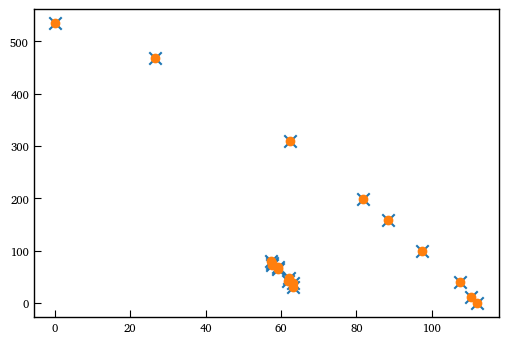

In [139]:
plt.scatter(df_AL[df_AL['group_id']==56162]['M_Rd'].values,
            df_AL[df_AL['group_id']==56162]['V_Rd'].values,
            marker='x',
            s=80)

plt.scatter(df_AL_fixed[df_AL_fixed['group_id']==56162]['M_Rd'].values,
            df_AL_fixed[df_AL_fixed['group_id']==56162]['V_Rd'].values)

#### Save Dataframe

In [59]:
df_AL.to_csv(DATA_SAVE_FILE, index=True)

#### Save Model

In [ ]:
model_AL.save(MODEL_SAVE_FILE)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Model saved to: Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth


### Load Dataframe & finetuned Model (given existing files)

In [51]:
directory.reset_root()
df_iter1 = pd.read_csv('Data\extended_profiles_iter_1.csv', index_col=0)
df_iter2 = pd.read_csv('Data\extended_profiles_iter_2.csv', index_col=0)
df_iter3 = pd.read_csv('Data\extended_profiles_iter_3.csv', index_col=0)
df_AL = pd.concat([df_AL, df_iter1, df_iter2, df_iter3], ignore_index=False)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [52]:
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [116]:
df_AL = pd.read_csv(DATA_SAVE_FILE)
model_AL = torch.load(MODEL_SAVE_FILE)
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

## Analysis of Results

### Model Performance

In [51]:
ids_added = np.array(list(df_AL.loc[len(df_full):].index))
ids_before = np.array(list(df_full.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds_before, _ = model.predict(df_AL)
y_truth_before = df_AL['target'].values

# Get Predictions after AL
y_preds_after, _ = model_AL.predict(df_AL)
y_truth_after = df_AL['target'].values

y_preds_after = y_preds_after.numpy().flatten()
y_preds_before = y_preds_before.numpy().flatten()

# Calculate relative error
error_before = np.abs((y_preds_before - y_truth_before) / y_truth_before+1e-8)
error_after = np.abs((y_preds_after[ids_before] - y_truth_after[ids_before]) / y_truth_after[ids_before]+1e-8)
error_added = np.abs((y_preds_after[ids_added] - y_truth_after[ids_added]) / y_truth_after[ids_added]+1e-8)

In [60]:
metrics_before = model.get_metrics()
metrics_after = model_AL.get_metrics()

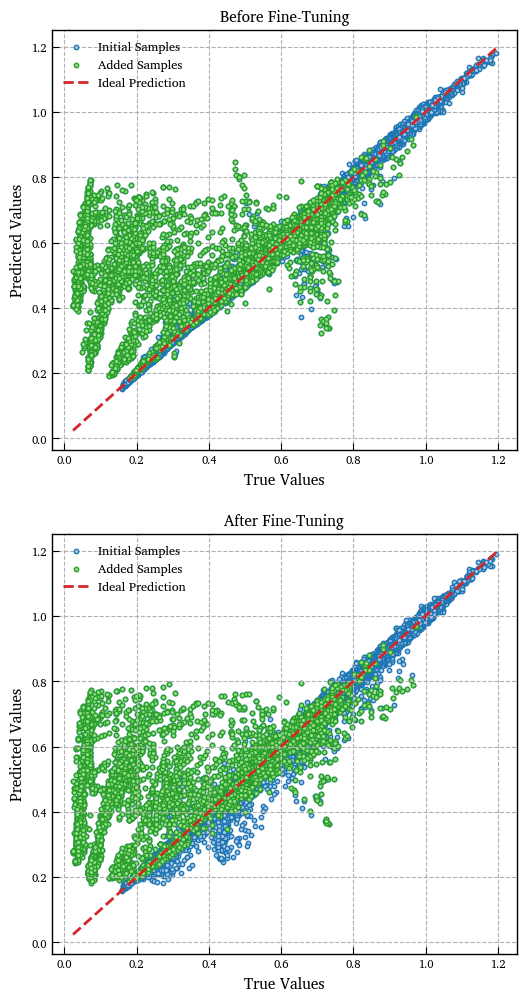

In [52]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

axs[0].scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=2
            )

axs[0].scatter(y_truth_before[ids_added], y_preds_before[ids_added],
               label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

axs[0].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[0].grid(True, linestyle='--', zorder=0)

axs[1].scatter(y_truth_after, y_preds_after, 
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10
            )

axs[1].scatter(y_truth_after[ids_added], y_preds_after[ids_added],
            label='Added Samples', 
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

axs[1].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[1].grid(True, linestyle='--', zorder=0)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Before Fine-Tuning')
axs[1].set_title('After Fine-Tuning')

axs[0].set_xlabel('True Values')
axs[1].set_xlabel('True Values')

axs[0].set_ylabel('Predicted Values')
axs[1].set_ylabel('Predicted Values')

plt.show()

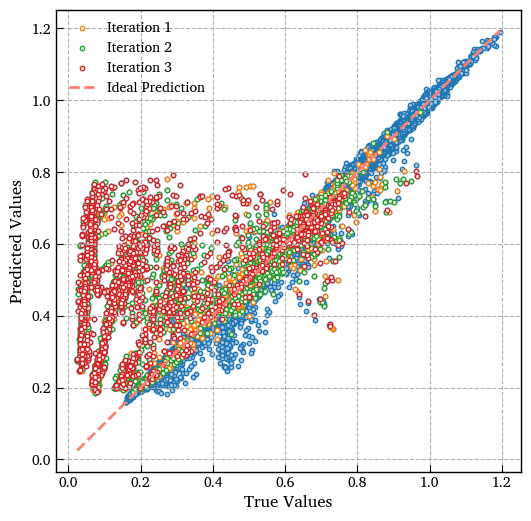

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_truth_after, y_preds_after, 
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            alpha=1.0
            )

for i in range(iterations):
    ax.scatter(y_truth_after[df_AL['iteration'] == i+1],
                y_preds_after[df_AL['iteration'] == i+1],
                label=f'Iteration {i+1}',
                facecolor='white',
                edgecolor=plot_params.morecolors[2*(i+1)],
                s=10,
                alpha=1.0
                )

ax.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

ax.grid(True, linestyle='--', zorder=0)
ax.legend()
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

plt.show()

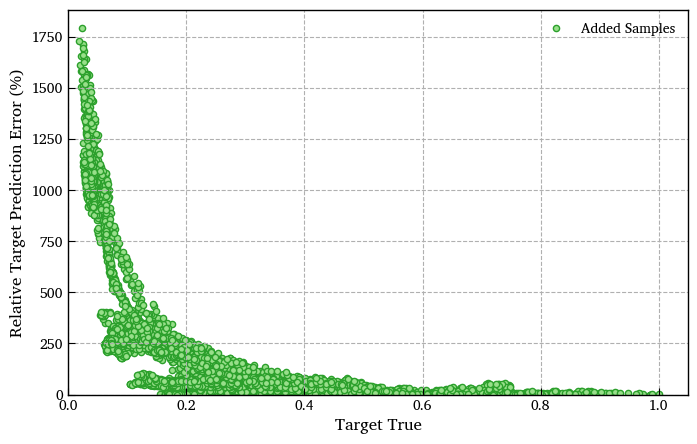

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(df_added['target'],error_added*100,
            label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=20
            )

plt.xlabel('Target True')
plt.ylabel('Relative Target Prediction Error (%)')
plt.legend()

plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True, linestyle='--', zorder=0)

plt.show()

### Loss Progression

Training and Validation Loss Spike

NameError: name 'epochs_per_iter' is not defined

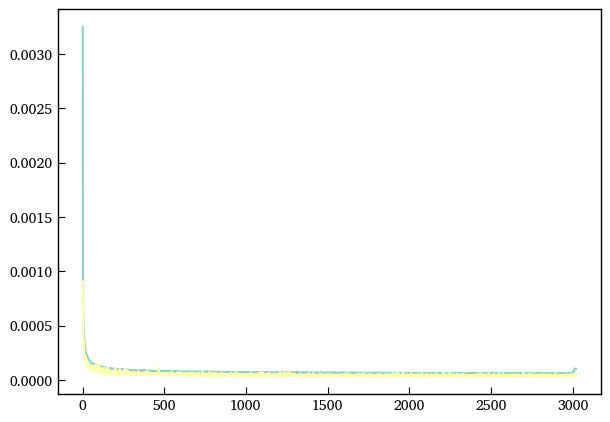

In [30]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model_AL.train_losses['total'], label='Training Loss', c=plot_params.colors[0],zorder=2)
plt.plot(model_AL.val_losses['total'], label='Validation Loss', c=plot_params.colors[1],zorder=2)

for i in range(iterations):
    iterations_start = model_AL.config['epochs'] + i * epochs_per_iter
    iterations_end = iterations_start + epochs_per_iter
    plt.axvline(x=iterations_start, color=plot_params.colors[2], linestyle='--',zorder=0)
    plt.axvline(x=iterations_end, color=plot_params.colors[2], linestyle='--',zorder=0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0.99*model.config['epochs'],model.config['epochs']+iterations*epochs_per_iter])
plt.yscale('log')
plt.legend()

### Features of Data Added

In [69]:
df_added = df_AL.loc[ids_added].copy()

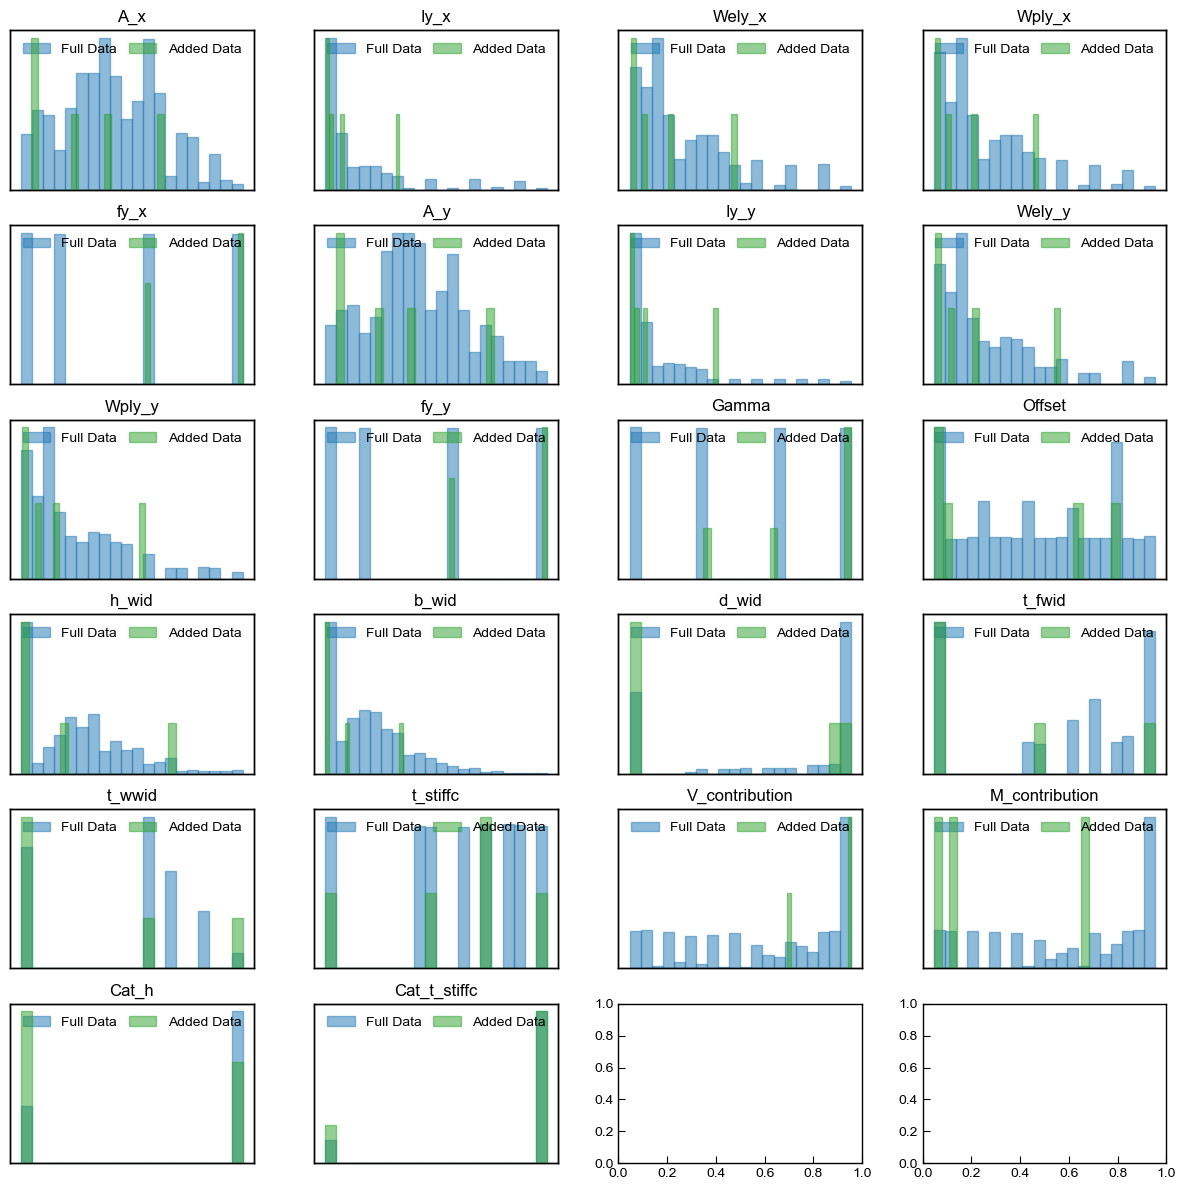

In [182]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_full[feature].values, bins=20, 
            edgecolor=plot_params.colors[0], 
            facecolor=plot_params.colors[0],
            alpha=0.5, label='Full Data')
    ax2.hist(df_added[feature].values, bins=20, 
             edgecolor=plot_params.colors[2],
             facecolor=plot_params.colors[2],
             alpha=0.5, label='Added Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Check added M-V location

In [117]:
def calculate_error(curve, points):
    curve = np.asarray(curve, dtype=float)
    points = np.atleast_2d(np.asarray(points, dtype=float))

    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    # Extracts the starting point of each segment — these are the anchors for the line segments.
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    # Scalar projection
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

In [118]:
def identify_computational_issue(df_group,threshold_x=0.2, threshold_y=0.2):
    if df_group.iloc[-1]['template'] != 'Corner.ideaCon':
        return False
    
    n_before = len(df_full)
    group = np.array(df_group.index)
    mask_before = np.where(np.array(group) < n_before)[0]
    mask_added = np.where(np.array(group) >= n_before)[0]

    M_Rd_calc = df_group['M_Rd'].values
    V_Rd_calc = df_group['V_Rd'].values

    base_profile = df_group.iloc[0].copy()
    M_Rd_pred, V_Rd_pred, _ = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

    # Calculate distance to interaction curve
    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
    added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T

    ids_on_y_axis = np.argmin(np.abs(added_resistances[:,0].reshape(-1,1)-interaction_curve[:,0]),axis=1)
    ids_on_x_axis = np.argmin(np.abs(added_resistances[:,1].reshape(-1,1)-interaction_curve[:,1]),axis=1)

    error_on_x = interaction_curve[:,0][ids_on_x_axis] - added_resistances[:,0].astype(float)
    error_on_y = interaction_curve[:,1][ids_on_y_axis] - added_resistances[:,1].astype(float)   

    rel_error_on_y = error_on_y / interaction_curve[:,1][ids_on_y_axis]
    rel_error_on_x = error_on_x / interaction_curve[:,0][ids_on_x_axis]

    if np.isnan(rel_error_on_x).any() or np.isinf(rel_error_on_x).any() or (rel_error_on_x < 0).any():
        return False
    if np.isnan(rel_error_on_y).any() or np.isinf(rel_error_on_y).any() or (rel_error_on_y < 0).any():
        return False
    
    if np.all(rel_error_on_y>threshold_y) and np.all(rel_error_on_x>threshold_x):
        print('Error on x:', rel_error_on_x)
        print('Error on y:', rel_error_on_y)
        return True
    
    return False

#### Plot MV Interaction Curve

Error on x: [0.3818873  0.38366104 0.35880787 0.35683494 0.37694541 0.35672369]
Error on y: [0.70879643 0.59565123 0.78791432 0.75795706 0.6522996  0.84164596]


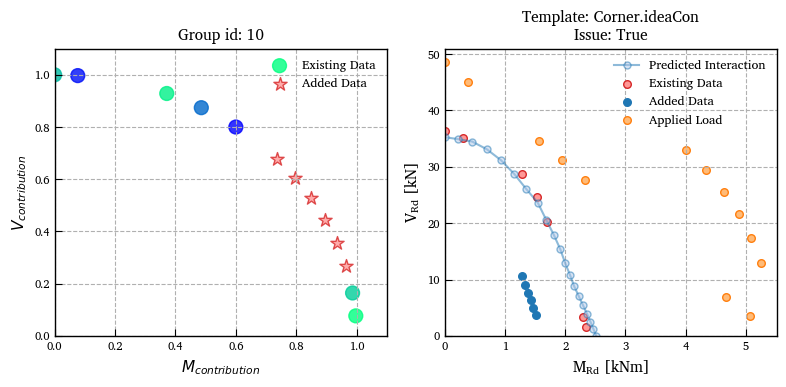

Error on x: [1.         0.92071642 0.95413187 0.88953869 0.90374172 0.93368203
 0.73672703 0.74995744 0.73078907]
Error on y: [0.47534808 0.554203   0.50906311 0.58852945 0.56822475 0.52843677
 0.82098684 0.81484849 0.83998969]


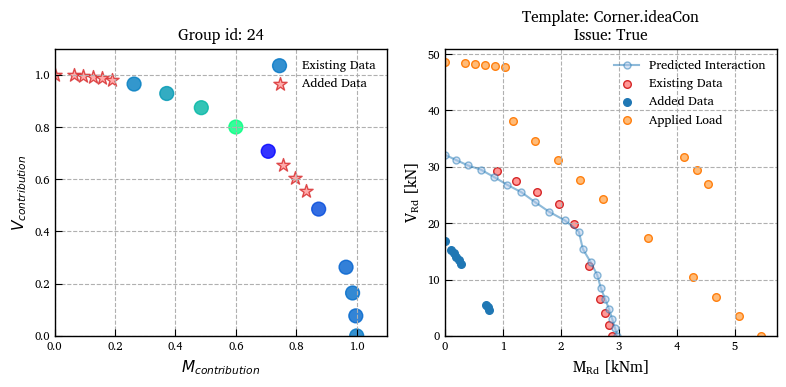

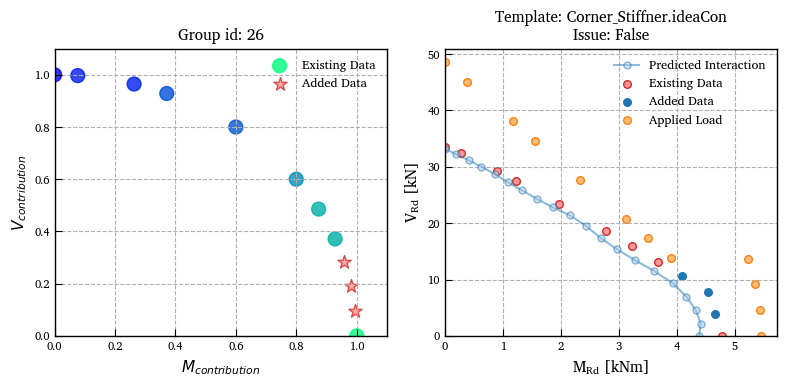

Error on x: [0.90635961 0.91158094 0.92356581 0.91133687 0.91184128 0.91130432]
Error on y: [1.         0.99001165 0.94883964 0.9960031  0.98603033 0.99800025]


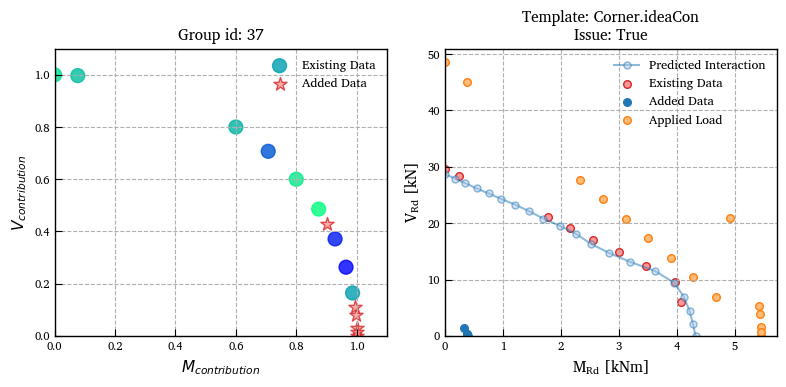

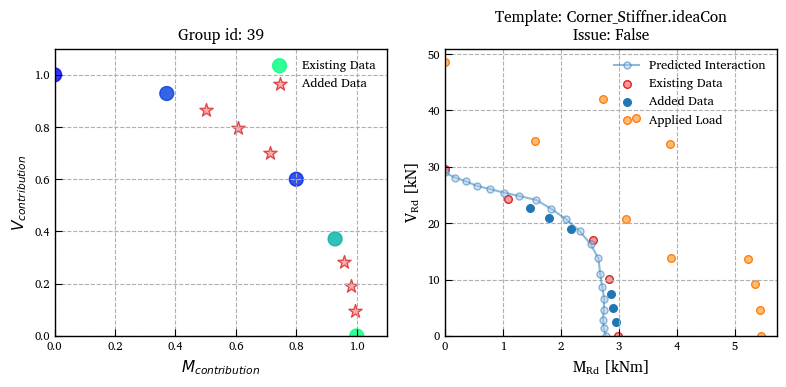

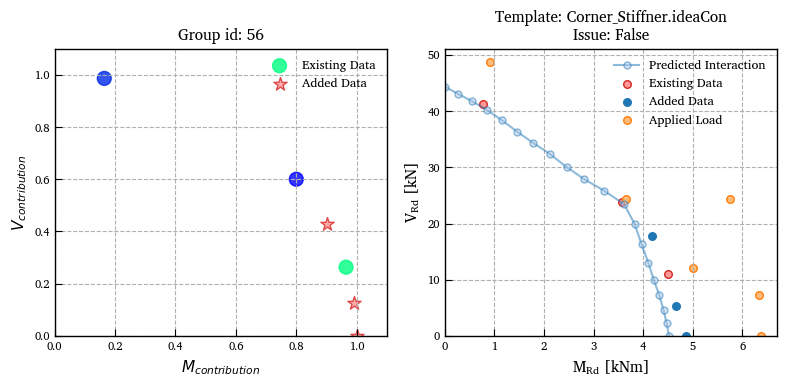

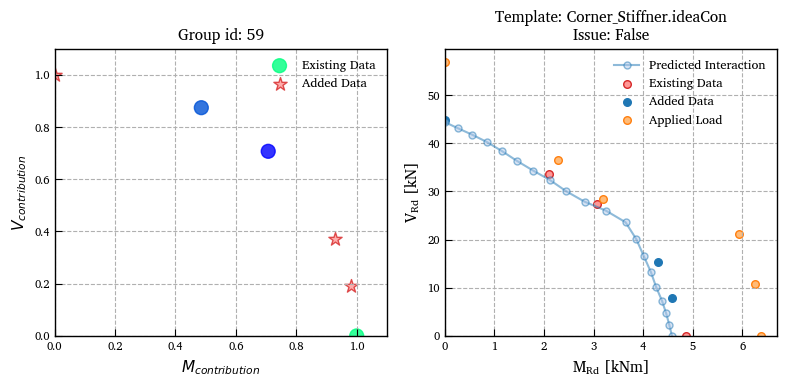

Error on x: [0.42722755 0.39759165 0.48210343 0.64319174 0.72096289 0.5735157 ]
Error on y: [0.47422645 0.57289001 0.44254558 0.34475759 0.30981222 0.38889286]


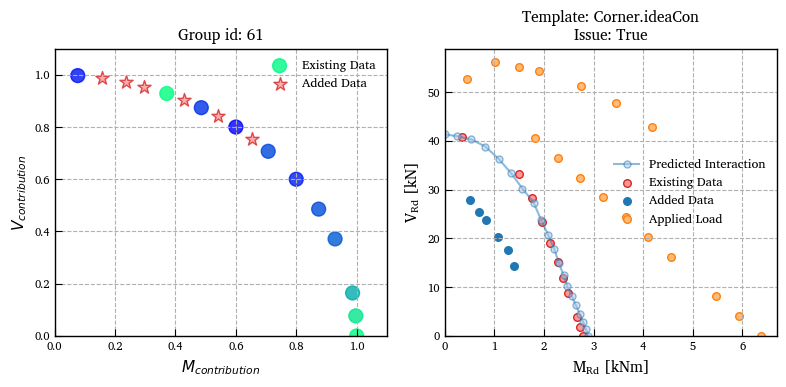

Error on x: [0.81120026 0.78856552 0.75310048 0.83292281 0.80113842 0.81888123
 0.74353592 0.76436437 0.76121092]
Error on y: [0.70233667 0.72683261 0.79379989 0.66623845 0.71345919 0.68416555
 0.81137333 0.77648479 0.78746232]


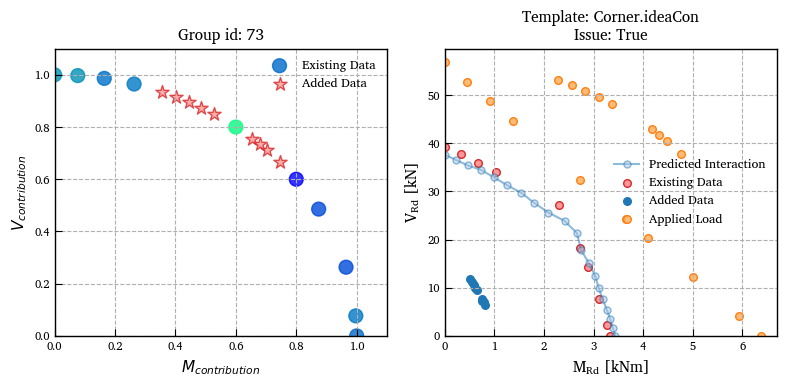

Error on x: [0.93185463 0.9306343  0.93777724 0.92911242 0.9347382  0.92835148]
Error on y: [0.91743511 0.93093088 0.91150073 0.92206385 0.91299506 0.93562326]


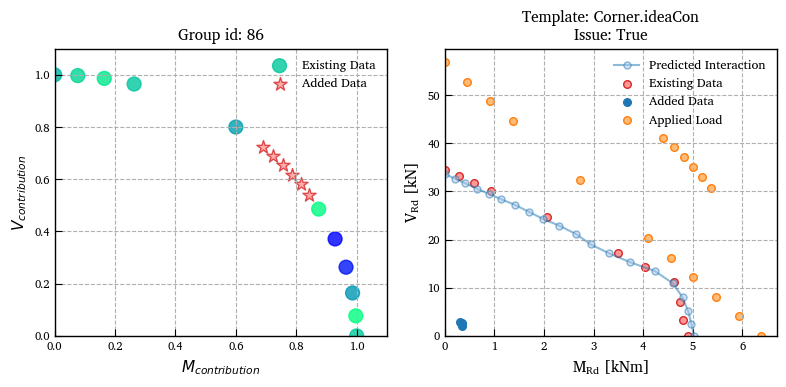

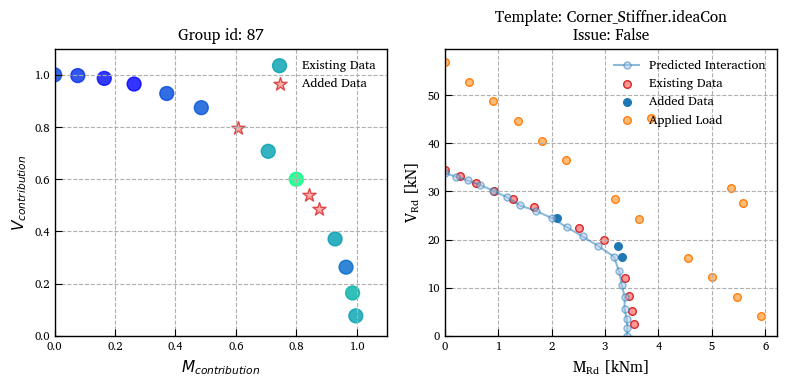

In [343]:
n_before = len(df_full)
counter = 0
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 10:
            break
        else:
            counter += 1

        M_contribution = df_AL.loc[group]['M_contribution'].values
        V_contribution = df_AL.loc[group]['V_contribution'].values
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        valid = identify_computational_issue(df_group)

        #correct_calculation = filter_wrong_calculations(df_group)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        #errors, closest_points = calculate_error(
        #    interaction_curve,
        #    added_resistances
        #)

        #vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        #rel_deviation = errors / vector_lengths

        fig, axs = plt.subplots(1,2,figsize=(8, 4))
        ax = axs[0]
        ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
                    label='Existing Data',
                    c=np.abs(error_before[np.array(group)[mask_before]]),
                    cmap='winter',
                    #vmin=0,
                    alpha=0.8,
                    s=100)
        ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
                    label='Added Data',
                    marker='*',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=0.8,
                    s=100)
        ax.set_xlabel(r'$M_{contribution}$')
        ax.set_ylabel(r'$V_{contribution}$')
        ax.grid(True, linestyle='--', zorder=0)
        ax.set_title(f"Group id: {group_id}")
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.legend()

        ax = axs[1]
        ax.plot(M_Rd_pred, V_Rd_pred, 
                    label='Predicted Interaction',
                    marker='o',
                    c=plot_params.morecolors[0],
                    markerfacecolor=plot_params.morecolors[1],
                    markeredgecolor=plot_params.morecolors[0],
                    alpha=0.5,
                    markersize=5)

        ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
                    label='Existing Data',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
                    label='Added Data',
                    #c=rel_deviation,
                    cmap='winter',
                    #vmin=0,
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M'].values, df_group['V'].values,
                    label='Applied Load',
                    facecolor=plot_params.morecolors[3],
                    edgecolor=plot_params.morecolors[2],
                    s=30)
        
        ax.set_title(f"Template: {df_AL.loc[group[-1]]['template']}\nIssue: {valid}")

        ax.set_xlabel(plot_params.feature_labels['M_Rd'])
        ax.set_ylabel(plot_params.feature_labels['V_Rd'])
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle='--', zorder=0)
        ax.legend()
        #ax.set_aspect('equal', adjustable='box')

        plt.tight_layout()
        plt.show()

### Analyse Errors

In [119]:
n_before = len(df_full)
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()

        calculation_error = identify_computational_issue(df_group)

        df_AL.loc[np.array(group)[mask_added], 'calculation_error'] = calculation_error

Error on x: [0.3818873  0.38366104 0.35880787 0.35683494 0.37694541 0.35672369]
Error on y: [0.70879643 0.59565123 0.78791432 0.75795706 0.6522996  0.84164596]
Error on x: [1.         0.92071642 0.95413187 0.88953869 0.90374172 0.93368203
 0.73672703 0.74995744 0.73078907]
Error on y: [0.47534808 0.554203   0.50906311 0.58852945 0.56822475 0.52843677
 0.82098684 0.81484849 0.83998969]
Error on x: [0.90635961 0.91158094 0.92356581 0.91133687 0.91184128 0.91130432]
Error on y: [1.         0.99001165 0.94883964 0.9960031  0.98603033 0.99800025]
Error on x: [0.42722755 0.39759165 0.48210343 0.64319174 0.72096289 0.5735157 ]
Error on y: [0.47422645 0.57289001 0.44254558 0.34475759 0.30981222 0.38889286]
Error on x: [0.81120026 0.78856552 0.75310048 0.83292281 0.80113842 0.81888123
 0.74353592 0.76436437 0.76121092]
Error on y: [0.70233667 0.72683261 0.79379989 0.66623845 0.71345919 0.68416555
 0.81137333 0.77648479 0.78746232]
Error on x: [0.93185463 0.9306343  0.93777724 0.92911242 0.93473

In [120]:
df_error = df_AL[~np.isnan(df_AL['calculation_error'].astype(float))].copy()

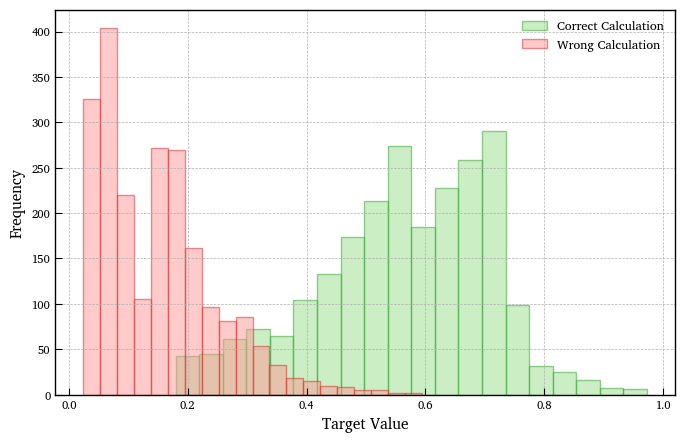

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.hist(df_error[df_error['calculation_error']==False]['target'], bins =20, 
         edgecolor=plot_params.morecolors[4], 
         facecolor=plot_params.morecolors[5],
         alpha=0.5, label='Correct Calculation')

plt.hist(df_error[df_error['calculation_error']==True]['target'], bins =20,
         edgecolor=plot_params.morecolors[6], 
         facecolor=plot_params.morecolors[7],
         alpha=0.5, label='Wrong Calculation')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

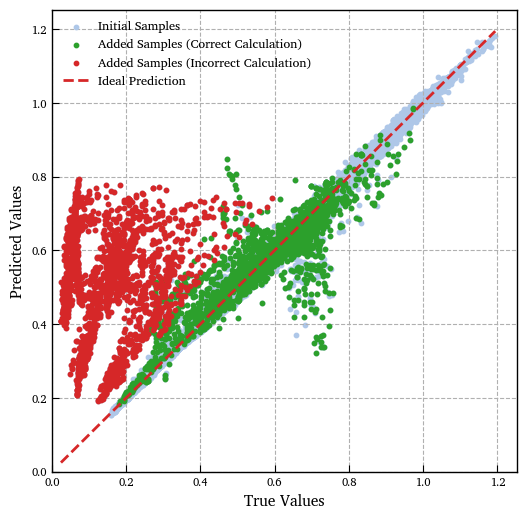

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[1],
            s=10,
            zorder=0,
            alpha=1.0
            )

plt.scatter(y_truth_before[ids_added[df_error['calculation_error']==False]], y_preds_before[ids_added[df_error['calculation_error']==False]],
               label='Added Samples (Correct Calculation)',
            facecolor=plot_params.morecolors[4],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

plt.scatter(y_truth_before[ids_added[df_error['calculation_error']==True]], y_preds_before[ids_added[df_error['calculation_error']==True]],
               label='Added Samples (Incorrect Calculation)',
            facecolor=plot_params.morecolors[6],
            edgecolor=plot_params.morecolors[6],
            s=10,
            zorder=2
            )

plt.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', zorder=0)
plt.xlim(0, None)
plt.ylim(0, None)

plt.legend()
plt.show()

### Correlations

#### Linear Correlation

In [123]:
df_error['calculation_error'] = df_error['calculation_error'].astype(float)

In [124]:
correlations = df_error.select_dtypes(include='number').corr()['calculation_error'].sort_values(ascending=False)
print(correlations)

calculation_error    1.000000
Unnamed: 0           0.511159
iteration            0.431369
V_contribution       0.182114
V                    0.167102
h_x                  0.165971
tw_y                 0.156436
h_y                  0.147632
b_x                  0.140180
A_y                  0.138702
tf_y                 0.136903
Av_y                 0.132793
group_id             0.132680
A_x                  0.130416
Av_x                 0.127779
b_y                  0.121319
Vpl_y                0.120996
Vpl_x                0.116361
Wely_y               0.109837
Wply_y               0.109685
tw_x                 0.108731
Wely_x               0.107396
Wply_x               0.106634
Mpl_y                0.104422
Mpl_x                0.101448
Gamma                0.094023
Iy_y                 0.088843
Offset_Idea          0.086314
Iy_x                 0.086180
tf_x                 0.075514
M                    0.071929
fy_x                -0.031052
fy_y                -0.031052
tau_x     

#### Random Forest

In [ ]:
counts = df_error.groupby('template')['calculation_error'].sum()
counts

template
Corner.ideaCon              2172.0
Corner_Stiff_Wid.ideaCon       0.0
Corner_Stiffner.ideaCon        0.0
Name: calculation_error, dtype: float64

In [136]:
rf_raw_features = ['h_x', 'b_x', 'tw_x', 'tf_x', 'A_x', 'Av_x',
       'Iy_x', 'Wely_x', 'Wply_x', 'fy_x', 'tau_x', 'Vpl_x',
       'Mpl_x', 'h_y', 'b_y', 'tw_y', 'tf_y', 'A_y', 'Av_y',
       'Iy_y', 'Wely_y', 'Wply_y', 'fy_y', 'tau_y', 'Vpl_y',
       'Mpl_y', 'Gamma', 't_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid',
       't_wwid', 't_stiffb', 'Offset', 'Offset_Idea',
       'Cat_h', 'Cat_t_stiffc']

Consider only samples calculated with Corner template.

Accuracy: 0.9910


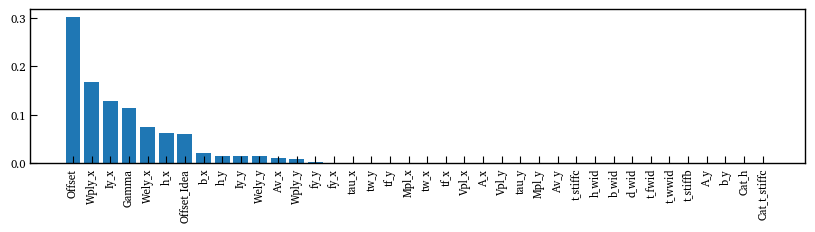

In [150]:
df_error_corner = df_error[
    (df_error[variable_features] == 0).all(axis=1)
]

X = df_error_corner[rf_raw_features].copy()
y = df_error_corner['calculation_error'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = XGBRFClassifier()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

importances = forest.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 2))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=plot_params.colors[0])
plt.xticks(rotation=90)
plt.show()

In [158]:
directory.reset_root()
error_identifier_package = {'features': rf_raw_features,
                            'model': forest}
with open(r'Saved Variables\RF_calculation_validation.pkl', 'wb') as f:
    pickle.dump(error_identifier_package, f)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


Consider all samples.

Accuracy: 0.9989


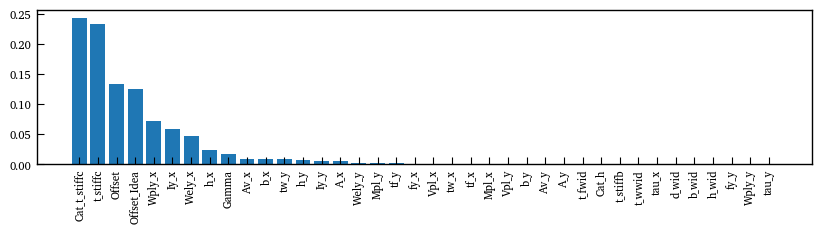

In [151]:
X = df_error[rf_raw_features].copy()
y = df_error['calculation_error'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = XGBRFClassifier()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

importances = forest.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 2))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=plot_params.colors[0])
plt.xticks(rotation=90)
plt.show()

### Uncertainty

In [402]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_added, num_samples=200)
uncertainty_added = mcd_std.flatten() / mcd_mean.flatten()

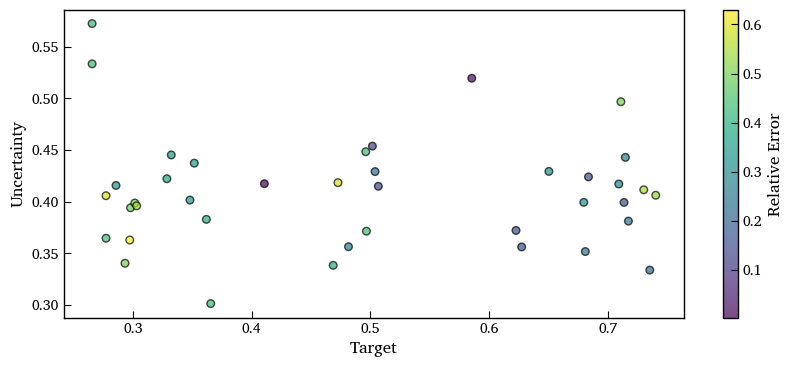

In [403]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(df_added['target'], uncertainty_added, label='Added Data',
            c=error_added, cmap='viridis', edgecolor='black', s=30, alpha=0.7)

plt.colorbar(label='Relative Error')
plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

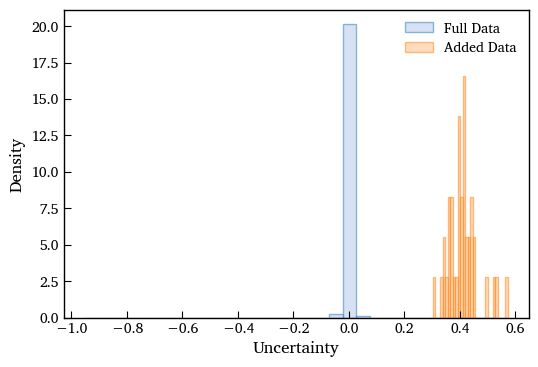

In [404]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=30,
         edgecolor=plot_params.morecolors[0], 
         facecolor=plot_params.morecolors[1], 
         alpha=0.5, label='Full Data',
         density=True)

plt.hist(uncertainty_added, bins=30, 
         edgecolor=plot_params.morecolors[2], 
         facecolor=plot_params.morecolors[3], 
         alpha=0.5, label='Added Data',
         density=True)

plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')

plt.show()

## Active Learning (with Filter)

In [ ]:
df_full_filtered = pd.read_csv(os.path.join(directory.root, "Data", "df_full_filtered.csv"), index_col=0)

In [ ]:
original_ids = df_full_filtered.index.copy()
df_full_filtered.reset_index(drop=True, inplace=True)

In [ ]:
model_AL = copy.deepcopy(model)
df_AL = df_full_filtered.copy()

df_AL.reset_index(drop=True, inplace=True)

df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [113]:
iterations = 1
groups_per_iter = 30
add_per_group = 2

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 60
Added Samples: 60


In [114]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [115]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 10, 5)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 5
Total Epochs: 5


In [116]:
save_interim_results = True

model_name = "DNN_Model_AL_Finetuned_FilterOn"
database_filename = "Extended_Database_FilterOn.csv"

MODEL_SAVE_PATH = os.path.join(directory.root, "Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

DATA_SAVE_FILE = os.path.join(directory.root, "Data", database_filename)

In [117]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_AL)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            #print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        get_MV(new_profiles)

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in unique_templates:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,df_new_profiles,profile_id)
            end_time = time.time()

            df_new_profiles.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1.0:
                results, loads, applied_percentage = underloaded(applied_percentage,df_new_profiles,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save_interim_results:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_filteron_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)

*** Iteration 1/1 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 13597)
   Processing Group 3.33% (Group id: 1545)
   Processing Group 6.67% (Group id: 1297)
   Processing Group 10.00% (Group id: 5353)
   Processing Group 13.33% (Group id: 6395)
   Processing Group 16.67% (Group id: 3325)
   Processing Group 20.00% (Group id: 3386)
   Processing Group 23.33% (Group id: 25882)
   Processing Group 26.67% (Group id: 13028)
   Processing Group 30.00% (Group id: 349)
   Processing Group 33.33% (Group id: 20912)
   Processing Group 36.67% (Group id: 1519)
   Processing Group 40.00% (Group id: 1332)
   Processing Group 43.33% (Group id: 13036)
   Processing Group 46.67% (Group id: 13001)
   Processing Group 50.00% (Group id: 3094)
   Processing Group 53.33% (Group id: 11656)
   Processing Group 56.67% (Group id: 26774)
   Processing Group 60.00% (Group id: 1748)
   Processing Group 63.33% (Group id: 3062)
   Processing Group 66.67% (Group id: 4876)
   Processing Group 70.00% (Grou

In [119]:
df_AL.to_csv(DATA_SAVE_FILE, index=True)

In [120]:
model_AL.save(MODEL_SAVE_FILE)

Model saved to: c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\Saved Models\DNN_Model_AL_Finetuned_FilterOn\DNN_Model_AL_Finetuned_FilterOn.pth


In [123]:
ids_added = np.array(list(df_AL.loc[len(df_full_filtered):].index))
ids_before = np.array(list(df_full_filtered.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds, _ = model.predict(df_AL)
y_truth = df_AL['target'].values

y_preds = y_preds.numpy().flatten()

# Calculate relative error
re_error = np.abs((y_preds - y_truth) / y_truth+1e-8)

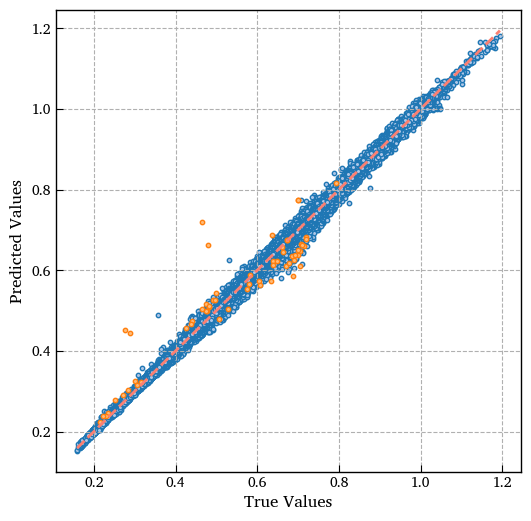

In [127]:
fig, axs = plt.subplots(figsize=(6, 6))

plt.scatter(y_truth[ids_before], y_preds[ids_before],
            label='Initial Samples',
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=0,
            alpha=1.0
            )

plt.scatter(y_truth[ids_added], y_preds[ids_added],
            label='Added Samples',
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            s=10,
            zorder=2
            )

plt.plot([y_truth.min(), y_truth.max()],
            [y_truth.min(), y_truth.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

plt.grid(True, linestyle='--', zorder=0)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()